In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import sys, os
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow_model_optimization as tfmot

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# sess.as_default()

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# for physical_device in physical_devices:
#     tf.config.experimental.set_memory_growth(physical_device, True)

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


In [5]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [6]:
tf.__version__

'2.2.0'

In [7]:
%matplotlib inline

In [8]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [9]:
train_data_dir = '../data/CollisionData/'

img_width, img_height = 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


### Model Architecture
MobileNet Base

Using imagenet weights as initialization. The entire architecture is retrainable.

In [11]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #change this to False is retraining is not to be done in base layers

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(1, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

base_model = MobileNet(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)

class_list = ['CollisionOrClose', 'NoCollision']
FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [12]:

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "MobileNetV1_OPT" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

In [13]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

### Model Size

In [14]:
shapes_count = int(np.sum([np.prod(np.array([s if isinstance(s, int) else 1 for s in l.output_shape])) for l in finetune_model.layers]))
memory = shapes_count * 4

print ("Model Size(mb): %d" % (memory/1000000))

Model Size(mb): 67


In [15]:


# trainable_count = int(np.sum([K.count_params(p) for p in set(finetune_model.trainable_weights)]))

# non_trainable_count = int(np.sum([K.count_params(p) for p in set(finetune_model.non_trainable_weights)]))

# print (trainable_count, non_trainable_count)

### Training and Testing

In [16]:

history = finetune_model.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True,) 

Epoch 1/10
45/45 [==============================] - 15s 344ms/step - loss: 0.8479 - accuracy: 0.7017 - val_accuracy: 0.7784 - val_loss: 0.4675
Epoch 2/10
45/45 [==============================] - 15s 335ms/step - loss: 0.6364 - accuracy: 0.7577 - val_accuracy: 0.8295 - val_loss: 0.3390
Epoch 3/10
45/45 [==============================] - 15s 337ms/step - loss: 0.4089 - accuracy: 0.8361 - val_accuracy: 0.8636 - val_loss: 0.2674
Epoch 4/10
45/45 [==============================] - 15s 337ms/step - loss: 0.3617 - accuracy: 0.8473 - val_accuracy: 0.9261 - val_loss: 0.2318
Epoch 5/10
45/45 [==============================] - 15s 337ms/step - loss: 0.3841 - accuracy: 0.8487 - val_accuracy: 0.9602 - val_loss: 0.2032
Epoch 6/10
45/45 [==============================] - 15s 337ms/step - loss: 0.3360 - accuracy: 0.8543 - val_accuracy: 0.9091 - val_loss: 0.2421
Epoch 7/10
45/45 [==============================] - 15s 336ms/step - loss: 0.2902 - accuracy: 0.8824 - val_accuracy: 0.9034 - val_loss: 0.1963

### Performance

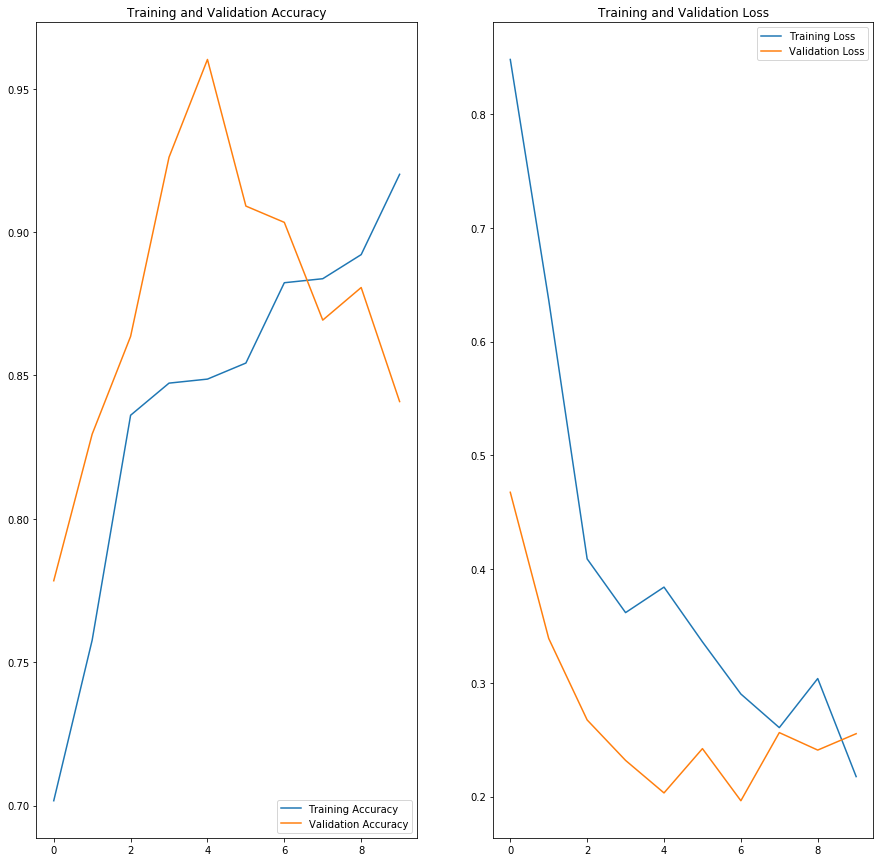

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
from keras.utils import Sequence


probabilities = finetune_model.predict_generator(generator=validation_generator)
print(probabilities)

Instructions for updating:
Please use Model.predict, which supports generators.
[[0.01592411]
 [0.02696909]
 [0.22592612]
 [0.08442339]
 [0.17268232]
 [0.03519477]
 [0.06224646]
 [0.03697171]
 [0.06818887]
 [0.0515182 ]
 [0.01006241]
 [0.0892874 ]
 [0.06929784]
 [0.12867156]
 [0.28325424]
 [0.06359696]
 [0.013428  ]
 [0.00971829]
 [0.01196347]
 [0.7684252 ]
 [0.02297917]
 [0.01647456]
 [0.07857738]
 [0.03930436]
 [0.462505  ]
 [0.30523002]
 [0.13853781]
 [0.11656087]
 [0.23674242]
 [0.24318099]
 [0.05576293]
 [0.45774913]
 [0.06772547]
 [0.31724665]
 [0.00967761]
 [0.05507071]
 [0.02250222]
 [0.02110741]
 [0.01612142]
 [0.07398181]
 [0.065441  ]
 [0.9872394 ]
 [0.9983359 ]
 [0.98706347]
 [0.99753654]
 [0.9871458 ]
 [0.99540305]
 [0.99724543]
 [0.99419725]
 [0.9921388 ]
 [0.9878179 ]
 [0.9723272 ]
 [0.988493  ]
 [0.98988473]
 [0.9967315 ]
 [0.9945703 ]
 [0.99795413]
 [0.97610587]
 [0.99818015]
 [0.9952219 ]
 [0.99126774]
 [0.99312264]
 [0.98399967]
 [0.99693847]
 [0.99572134]
 [0.977482

In [21]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [22]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

CollisionOrClose       0.62      0.98      0.76        41
     NoCollision       0.99      0.83      0.90       140

        accuracy                           0.86       181
       macro avg       0.81      0.90      0.83       181
    weighted avg       0.91      0.86      0.87       181



In [23]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[ 40   1]
 [ 24 116]]


### Analyze Results

In [24]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

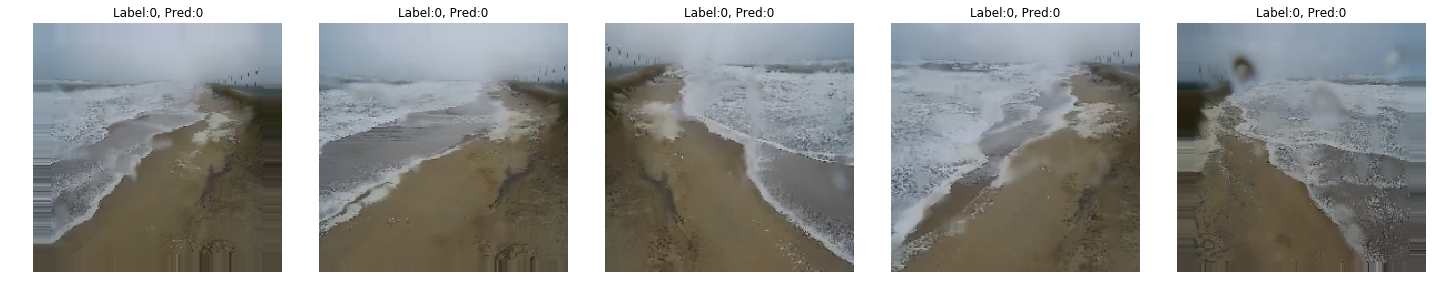

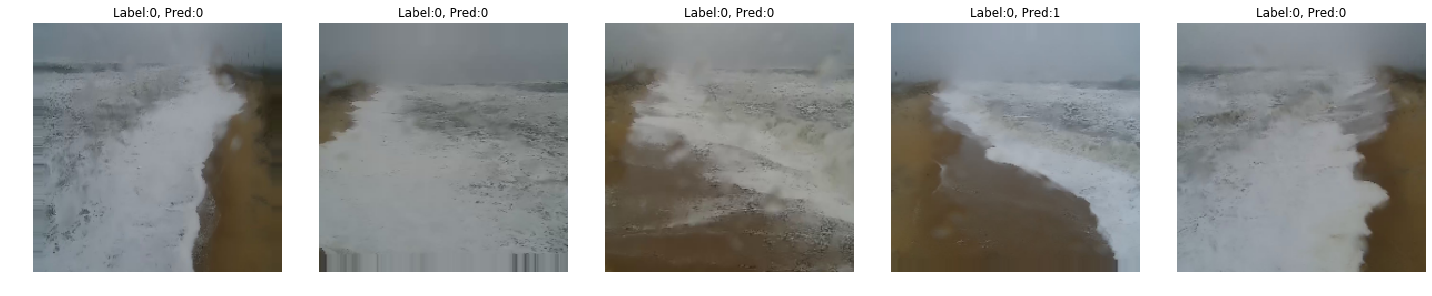

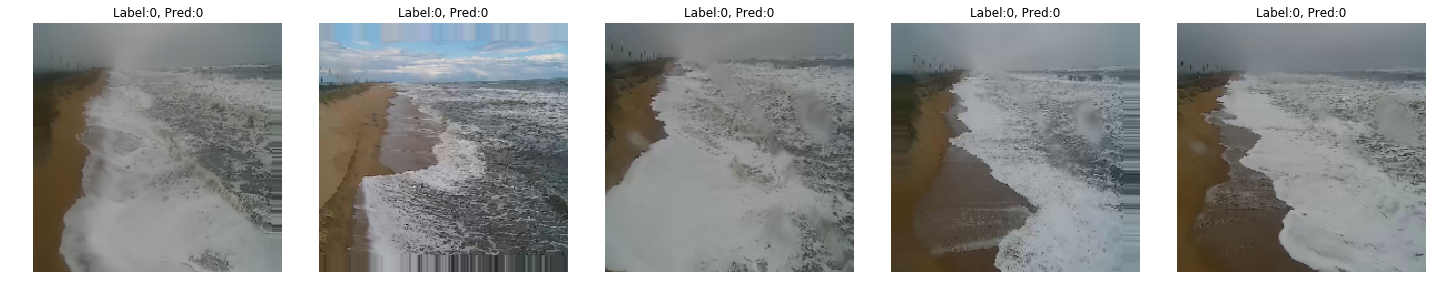

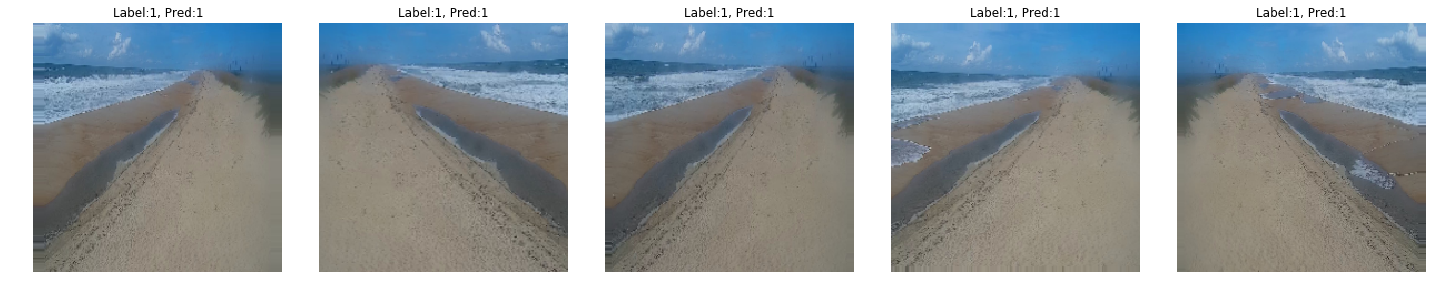

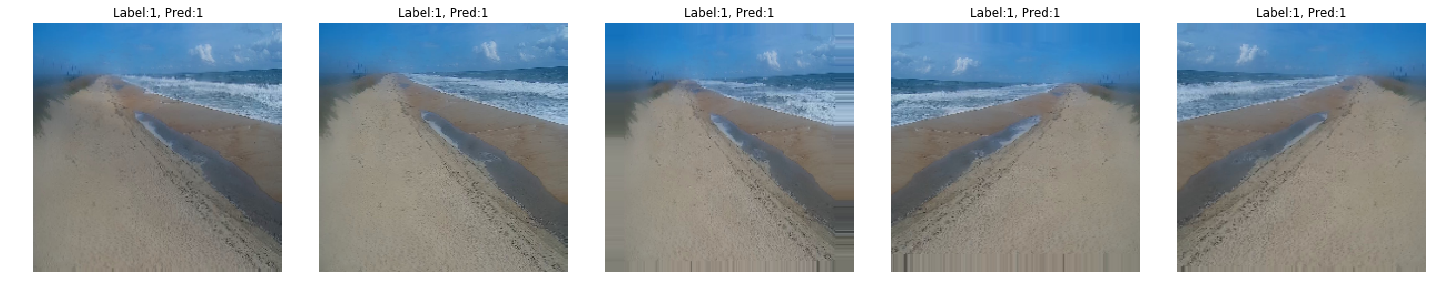

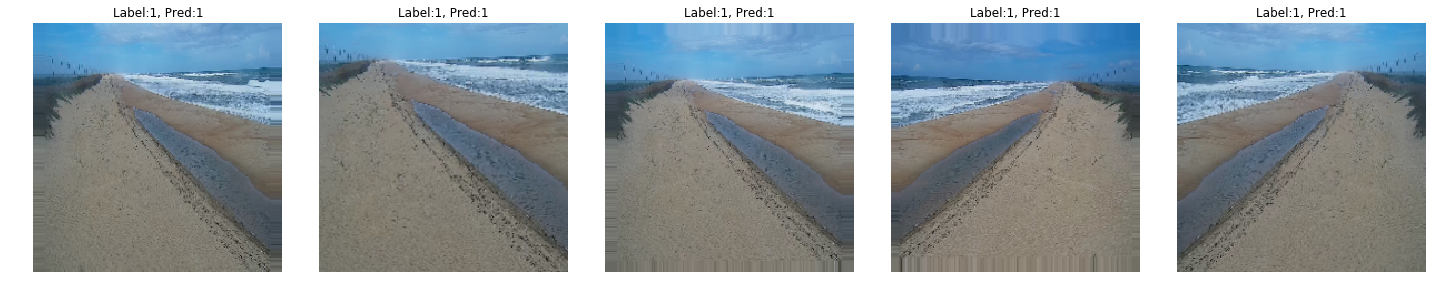

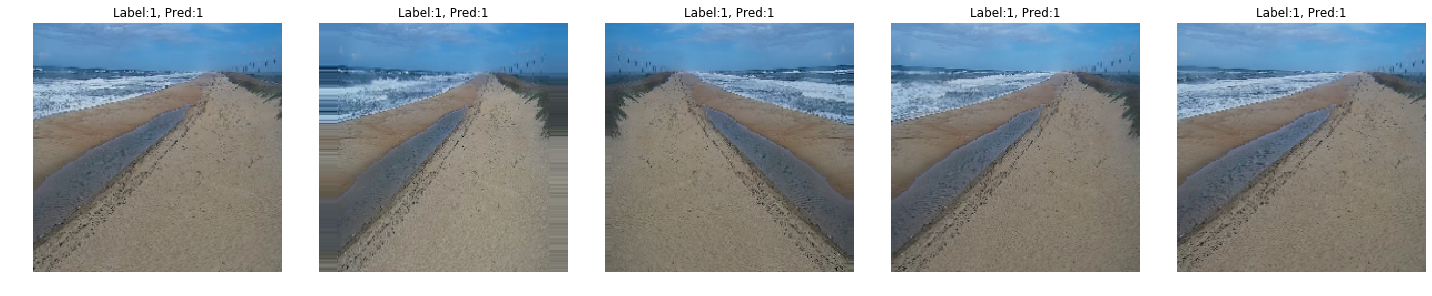

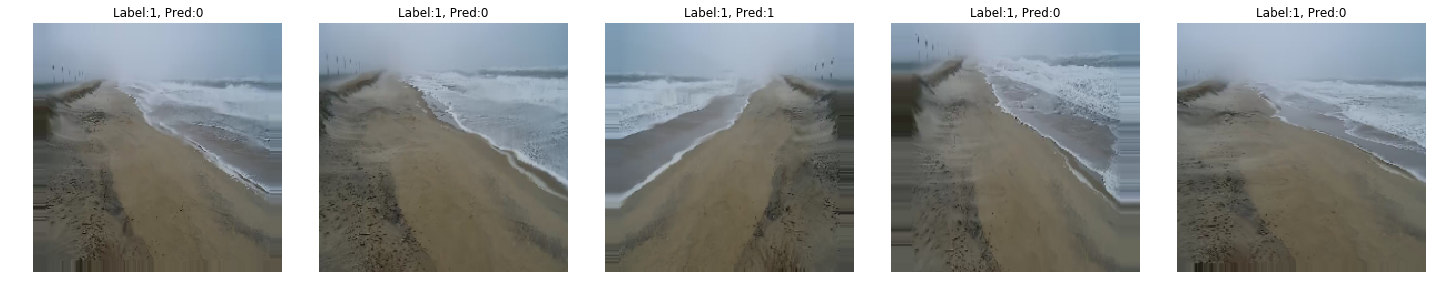

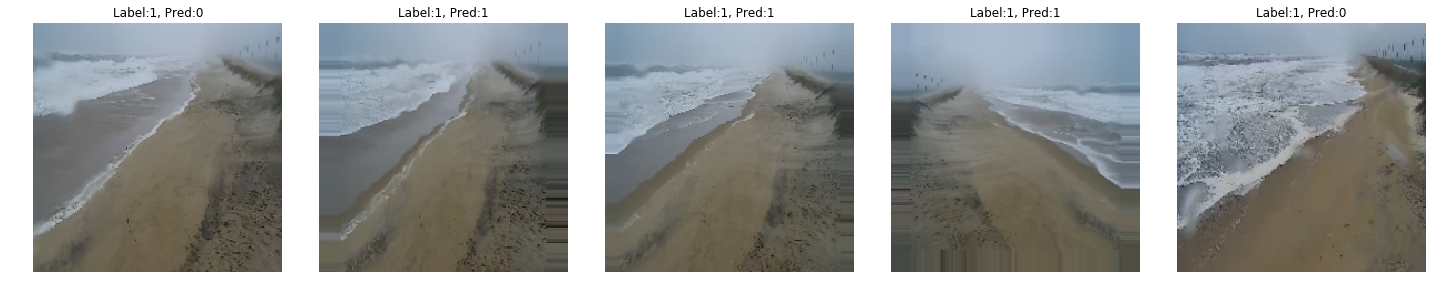

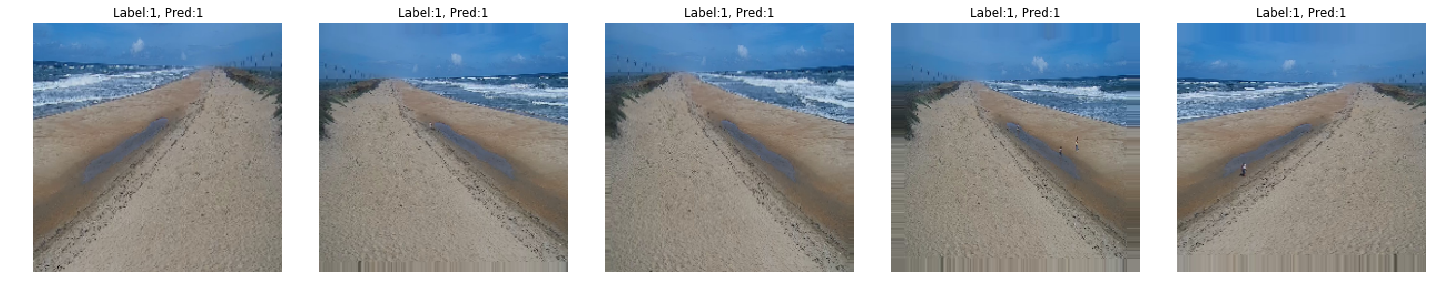

In [25]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [26]:
labels = (validation_generator.class_indices)

In [27]:
labels

{'CollisionOrClose': 0, 'NoCollision': 1}

## Optimization

### Pruning

In [62]:
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
                        initial_sparsity=0.0, final_sparsity=0.5,
                        begin_step=2000, end_step=4000)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(finetune_model, pruning_schedule=pruning_schedule)


Instructions for updating:
Please use `layer.add_weight` method instead.


In [63]:
trainable_count = np.sum([K.count_params(w) for w in finetune_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in finetune_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 16,140,225
Trainable params: 16,118,337
Non-trainable params: 21,888


### Quantization

In [20]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer


def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #change this to False is retraining is not to be done in base layers

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # New sigmoid layer
    predictions = Dense(1, activation='sigmoid')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

base_model = MobileNet(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)

class_list = ['CollisionOrClose', 'NoCollision']
FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

Quantizing all layers except last layer. In the last layer skip activation quantization `sigmoid` activation is not supported

In [31]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    def get_activations_and_quantizers(self, layer):
      # Skip quantizing activations.
        return []

    def set_quantize_activations(self, layer, quantize_activations):
      # Empty since `get_activaations_and_quantizers` returns
      # an empty list.
        return


quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class CustomLayer(tf.keras.layers.Dense):
    pass

def annotate(layer):
    if layer._name.startswith('dense_6'):
        return tfmot.quantization.keras.quantize_annotate_layer(layer, ModifiedDenseQuantizeConfig())
    # quantize everything else
    return tfmot.quantization.keras.quantize_annotate_layer(layer)


annotated_model = tf.keras.models.clone_model(finetune_model, clone_function=annotate)

with quantize_scope({'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
    # Use `quantize_apply` to actually make the model quantization aware.
    quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()



here
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
quantize_layer_9 (QuantizeLa (None, 224, 224, 3)       3         
_________________________________________________________________
quant_conv1_pad (QuantizeWra (None, 225, 225, 3)       1         
_________________________________________________________________
quant_conv1 (QuantizeWrapper (None, 112, 112, 32)      929       
_________________________________________________________________
quant_conv1_bn (QuantizeWrap (None, 112, 112, 32)      129       
_________________________________________________________________
quant_conv1_relu (QuantizeWr (None, 112, 112, 32)      3         
_________________________________________________________________
quant_conv_dw_1 (QuantizeWra (None, 112, 112, 32)     

A different way of quantizing, skiping quantizing the last layer completely

In [27]:
# def annotate(layer):
#     if layer._name.startswith('dense_6'):
#         print("here")
#         return layer   # pass thru; don't quantize tf.image.resize()
#     # quantize everything else
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)

# annotated_model = tf.keras.models.clone_model(finetune_model, clone_function=annotate)

# quantized_model = tfmot.quantization.keras.quantize_apply(annotated_model)
# quantized_model.summary()

here
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
quantize_layer_5 (QuantizeLa (None, 224, 224, 3)       3         
_________________________________________________________________
quant_conv1_pad (QuantizeWra (None, 225, 225, 3)       1         
_________________________________________________________________
quant_conv1 (QuantizeWrapper (None, 112, 112, 32)      929       
_________________________________________________________________
quant_conv1_bn (QuantizeWrap (None, 112, 112, 32)      129       
_________________________________________________________________
quant_conv1_relu (QuantizeWr (None, 112, 112, 32)      3         
_________________________________________________________________
quant_conv_dw_1 (QuantizeWra (None, 112, 112, 32)     

Model quantization does not work because of `sigmoid`

In [ ]:
# # Quantize the entire model.
# quantized_model = tfmot.quantization.keras.quantize_model(finetune_model)

# # Continue with training as usual.
# quantized_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
trainable_count = np.sum([K.count_params(w) for w in finetune_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in finetune_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 16,140,225
Trainable params: 16,118,337
Non-trainable params: 21,888


In [43]:
shapes_count = int(np.sum([np.prod(np.array([s if isinstance(s, int) else 1 for s in l.output_shape])) for l in finetune_model.layers]))
memory = shapes_count * 4

print ("Model Size(mb): %d" % (memory/1000000))

Model Size(mb): 68


In [36]:
trainable_count = np.sum([K.count_params(w) for w in quant_aware_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in quant_aware_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 16,152,378.0
Trainable params: 16,118,337
Non-trainable params: 34,041.0


In [38]:
quant_aware_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
history = quant_aware_model.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True,) 

Epoch 1/10
45/45 [==============================] - 16s 359ms/step - loss: 0.3627 - accuracy: 0.8501 - val_accuracy: 0.8807 - val_loss: 0.2328
Epoch 2/10
45/45 [==============================] - 16s 345ms/step - loss: 0.1837 - accuracy: 0.9258 - val_accuracy: 0.8239 - val_loss: 0.3265
Epoch 3/10
45/45 [==============================] - 16s 348ms/step - loss: 0.1504 - accuracy: 0.9375 - val_accuracy: 0.8352 - val_loss: 0.3253
Epoch 4/10
45/45 [==============================] - 16s 350ms/step - loss: 0.1478 - accuracy: 0.9398 - val_accuracy: 0.8239 - val_loss: 0.3044
Epoch 5/10
45/45 [==============================] - 15s 344ms/step - loss: 0.1017 - accuracy: 0.9566 - val_accuracy: 0.9091 - val_loss: 0.1876
Epoch 6/10
45/45 [==============================] - 15s 343ms/step - loss: 0.0978 - accuracy: 0.9636 - val_accuracy: 0.8409 - val_loss: 0.4133
Epoch 7/10
45/45 [==============================] - 15s 344ms/step - loss: 0.1020 - accuracy: 0.9706 - val_accuracy: 0.8239 - val_loss: 0.4187

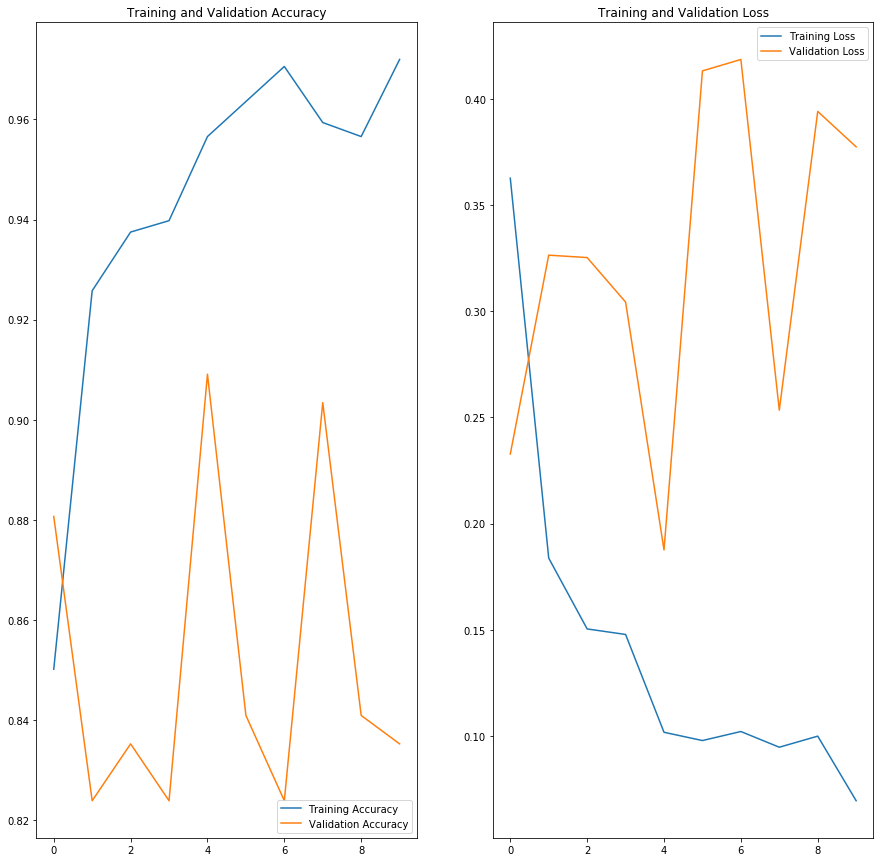

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
probabilities = quant_aware_model.predict_generator(generator=validation_generator)
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys()) 

Instructions for updating:
Please use Model.predict, which supports generators.


In [45]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

     NoCollision       0.59      0.98      0.73        41
CollisionOrClose       0.99      0.80      0.89       140

        accuracy                           0.84       181
       macro avg       0.79      0.89      0.81       181
    weighted avg       0.90      0.84      0.85       181



In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [48]:
import tempfile

_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
    f.write(quantized_tflite_model)
    
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

Quantized model in Mb: 61.65117263793945
